In [1]:
pip install pandas openpyxl ccxt numpy matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.5/131.5 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 35.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 628.0/628.0 kB 33.6 MB/s eta 0:00:00


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving BTC_spot_ETF_data_20250709.xlsx to BTC_spot_ETF_data_20250709 (2).xlsx


In [8]:
import pandas as pd
import ccxt
import numpy as np
import traceback
import io
import time
from datetime import datetime
from collections import deque # Import deque for efficient FIFO queue

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

# --- Configuration Parameters ---
INITIAL_CAPITAL = 300000.0
POSITION_INVESTMENT_AMOUNT = 75000.0
TRANSACTION_COST_PCT = 0.001

BTC_SYMBOL = 'BTC/USDT'
EXCHANGE_NAME = 'coinbase'

Running in a Colab environment. Please upload your file.


Saving BTC_spot_ETF_data_20250721.xlsx to BTC_spot_ETF_data_20250721 (12).xlsx
User uploaded file "BTC_spot_ETF_data_20250721 (12).xlsx"

Loading data...
Fetching BTC data from coinbase starting from 2024-01-10T00:00:00.000Z...
Fetching BTC data from coinbase starting from 2024-11-05T00:00:00.000Z...

--- Starting 2D Optimization with FIFO Selling Logic ---
Initial Capital: $300,000.00, Position Size: $75,000.00
  Testing Buy: $200M, Sell: $250M
  Testing Buy: $200M, Sell: $260M
  Testing Buy: $200M, Sell: $270M
  Testing Buy: $200M, Sell: $280M
  Testing Buy: $200M, Sell: $290M
  Testing Buy: $200M, Sell: $300M
  Testing Buy: $210M, Sell: $250M
  Testing Buy: $210M, Sell: $260M
  Testing Buy: $210M, Sell: $270M
  Testing Buy: $210M, Sell: $280M
  Testing Buy: $210M, Sell: $290M
  Testing Buy: $210M, Sell: $300M
  Testing Buy: $220M, Sell: $250M
  Testing Buy: $220M, Sell: $260M
  Testing Buy: $220M, Sell: $270M
  Testing Buy: $220M, Sell: $280M
  Testing Buy: $220M, Sell: $290M
  Test

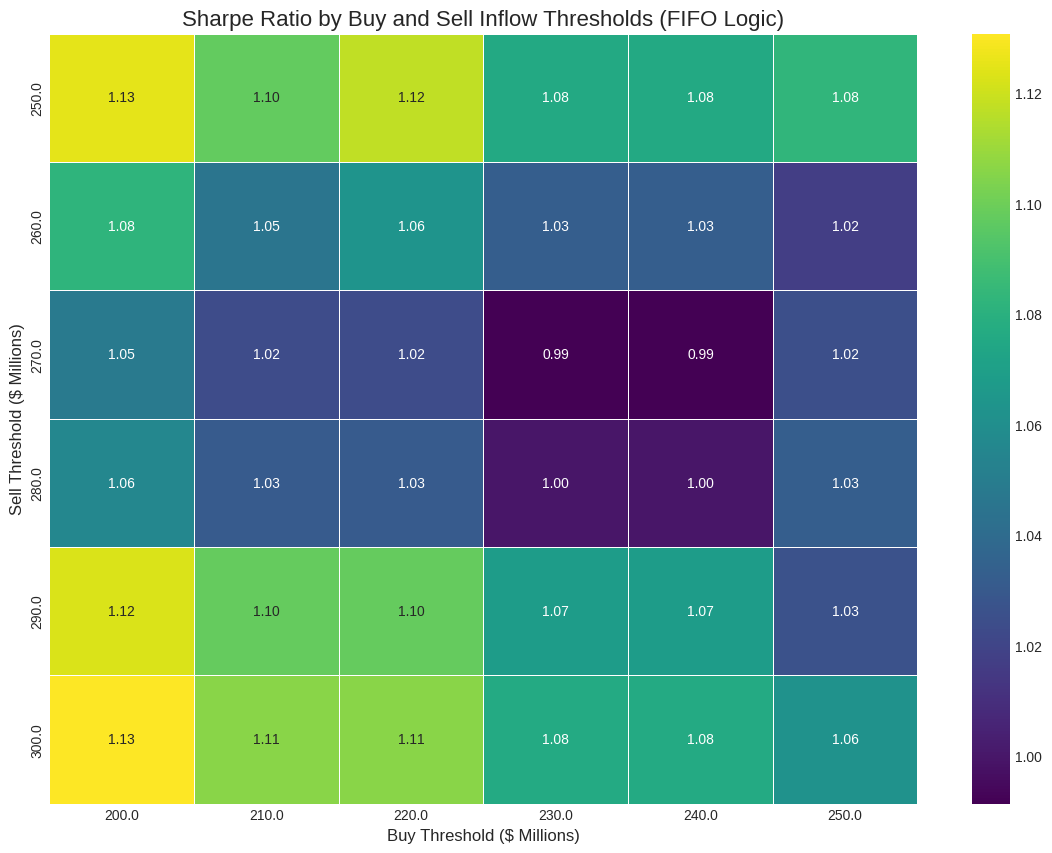

In [17]:
# --- Data Loading and Preparation Functions (no changes) ---
def load_etf_data(file_source):
    """Loads and prepares the ETF inflow data from the uploaded Excel file."""
    try:
        df = pd.read_excel(file_source)
        if 'Date' not in df.columns or 'NetInflow' not in df.columns:
            raise ValueError("Excel file must contain 'Date' and 'NetInflow' columns.")
        df['Date'] = pd.to_datetime(df['Date'])
        df = df.sort_values(by='Date')
        df.set_index('Date', inplace=True)
        df = df.resample('D').sum()
        return df
    except Exception as e:
        print(f"Error loading ETF data: {e}")
        return None

def fetch_btc_price_data_full(symbol, exchange_name, start_date_str, end_date_str):
    """Fetches daily OHLCV data for Bitcoin from the specified exchange."""
    try:
        exchange = getattr(ccxt, exchange_name)()
    except AttributeError:
        print(f"Error: Exchange '{exchange_name}' not found by ccxt.")
        return None
    if not exchange.has['fetchOHLCV']: return None
    all_ohlcv = []
    since = exchange.parse8601(start_date_str + 'T00:00:00Z')
    end_timestamp = exchange.parse8601(end_date_str + 'T23:59:59Z')
    limit = 1000
    while since < end_timestamp:
        try:
            print(f"Fetching BTC data from {exchange_name} starting from {exchange.iso8601(since)}...")
            ohlcv = exchange.fetch_ohlcv(symbol, '1d', since, limit)
            if not ohlcv: break
            ohlcv = [c for c in ohlcv if c[0] <= end_timestamp]
            if not ohlcv: break
            all_ohlcv.extend(ohlcv)
            since = ohlcv[-1][0] + 86400000
            time.sleep(exchange.rateLimit / 1000)
        except Exception as e:
            print(f"An error occurred while fetching BTC data: {e}"); traceback.print_exc(); return None
    if not all_ohlcv: return None
    df = pd.DataFrame(all_ohlcv, columns=['timestamp', 'Open', 'High', 'Low', 'Close', 'Volume'])
    df['Date'] = pd.to_datetime(df['timestamp'], unit='ms')
    df = df.drop_duplicates(subset='timestamp').sort_values(by='Date')
    df.set_index('Date', inplace=True)
    return df[['Open', 'High', 'Low', 'Close', 'Volume']]

def align_data(etf_df, btc_df):
    """Aligns the ETF and BTC dataframes on their date index."""
    if etf_df is None or btc_df is None: return None
    if etf_df.index.tz is not None: etf_df.index = etf_df.index.tz_localize(None)
    if btc_df.index.tz is not None: btc_df.index = btc_df.index.tz_localize(None)
    combined_df = pd.merge(btc_df, etf_df, left_index=True, right_index=True, how='inner')
    combined_df['NetInflow_shifted'] = combined_df['NetInflow'].shift(1)
    combined_df.dropna(subset=['NetInflow_shifted'], inplace=True)
    return combined_df

def generate_signals_asymmetric_threshold(df, buy_threshold, sell_threshold):
    """Generates signals based on separate buy and sell inflow thresholds."""
    df_signal = df.copy()
    df_signal['Signal'] = 0
    df_signal.loc[df_signal['NetInflow_shifted'] > buy_threshold, 'Signal'] = 1
    df_signal.loc[df_signal['NetInflow_shifted'] < -sell_threshold, 'Signal'] = -1
    return df_signal

# --- NEW: Backtesting Function with FIFO Logic ---
def run_backtest_fifo(df, initial_capital, position_investment, transaction_cost_pct):
    """
    Runs the backtest using a First-In, First-Out (FIFO) logic for selling.
    Each buy is a 'lot' stored in a queue. Sells consume the oldest lot.
    """
    cash = initial_capital
    # Use a deque to store lots as tuples: (btc_amount, entry_price)
    position_lots = deque()
    portfolio_values = []
    num_trades = 0
    num_wins = 0

    for i in range(len(df)):
        date, today_open, today_close, signal = df.index[i], df['Open'].iloc[i], df['Close'].iloc[i], df['Signal'].iloc[i]

        # --- Buy Logic: Add a new lot to the queue ---
        if signal == 1 and cash >= position_investment:
            buy_price = today_open
            btc_to_acquire = position_investment / buy_price
            fee = position_investment * transaction_cost_pct

            cash -= (position_investment + fee)

            # Add the new purchase as a distinct lot
            position_lots.append({'btc_amount': btc_to_acquire, 'entry_price': buy_price})

        # --- Sell Logic: Sell the oldest lot (FIFO) ---
        elif signal == -1 and position_lots: # Check if there are any lots to sell
            sell_price = today_open

            # Get the oldest lot from the front of the queue
            oldest_lot = position_lots.popleft()
            btc_to_sell = oldest_lot['btc_amount']
            entry_price_of_lot = oldest_lot['entry_price']

            # Execute the sale
            proceeds = btc_to_sell * sell_price
            fee = proceeds * transaction_cost_pct
            cash += (proceeds - fee)

            # Track trade performance based on this specific lot
            num_trades += 1
            if sell_price > entry_price_of_lot:
                num_wins += 1

        # --- Daily Portfolio Valuation ---
        # Calculate the current value of all BTC held across all lots
        total_btc_held = sum(lot['btc_amount'] for lot in position_lots)
        current_btc_value = total_btc_held * today_close
        current_portfolio_value = cash + current_btc_value
        portfolio_values.append({'Date': date, 'PortfolioValue': current_portfolio_value})

    portfolio_df = pd.DataFrame(portfolio_values).set_index('Date') if portfolio_values else None
    return {'portfolio_df': portfolio_df, 'num_trades': num_trades, 'num_wins': num_wins}

def calculate_performance_metrics(portfolio_df, initial_capital):
    """Calculates key performance metrics from the portfolio value history."""
    if portfolio_df is None or portfolio_df.empty or len(portfolio_df) < 2:
        return {'Sharpe Ratio': 0, 'Total Return (%)': 0, 'Max Drawdown (%)': 0}
    metrics = {}
    final_value = portfolio_df['PortfolioValue'].iloc[-1]
    metrics['Total Return (%)'] = ((final_value / initial_capital) - 1) * 100
    portfolio_df['Peak'] = portfolio_df['PortfolioValue'].cummax()
    portfolio_df['Drawdown'] = (portfolio_df['PortfolioValue'] - portfolio_df['Peak']) / portfolio_df['Peak']
    metrics['Max Drawdown (%)'] = portfolio_df['Drawdown'].min() * 100
    portfolio_df['Daily Return'] = portfolio_df['PortfolioValue'].pct_change()
    avg_daily_return = portfolio_df['Daily Return'].mean()
    std_daily_return = portfolio_df['Daily Return'].std()
    if std_daily_return != 0 and not np.isnan(std_daily_return):
        metrics['Sharpe Ratio'] = (avg_daily_return / std_daily_return) * np.sqrt(252)
    else:
        metrics['Sharpe Ratio'] = 0.0
    return metrics

# --- Main Execution Block ---
if __name__ == '__main__':
    file_source = None
    try:
        from google.colab import files
        print("Running in a Colab environment. Please upload your file.")
        uploaded = files.upload()
        if uploaded:
            filename = next(iter(uploaded))
            print(f'User uploaded file "{filename}"')
            file_source = io.BytesIO(uploaded[filename])
        else:
            print("No file was uploaded."); exit()
    except (ImportError, ModuleNotFoundError):
        print("Not in Colab. This script is designed for Google Colab. Exiting."); exit()

    print("\nLoading data...")
    etf_df = load_etf_data(file_source)
    if etf_df is None: exit()

    start_date_btc = etf_df.index.min().strftime('%Y-%m-%d')
    end_date_btc = etf_df.index.max().strftime('%Y-%m-%d')

    btc_df = fetch_btc_price_data_full(BTC_SYMBOL, EXCHANGE_NAME, start_date_btc, end_date_btc)
    if btc_df is None: exit()

    base_data = align_data(etf_df, btc_df)
    if base_data is None or base_data.empty:
        print("Could not align data. Exiting."); exit()

    # --- 2D Optimization Loop ---
    buy_threshold_options = range(200_000_000, 251_000_000, 10_000_000)
    sell_threshold_options = range(250_000_000, 301_000_000, 10_000_000)
    optimization_results = []

    print("\n--- Starting 2D Optimization with FIFO Selling Logic ---")
    print(f"Initial Capital: ${INITIAL_CAPITAL:,.2f}, Position Size: ${POSITION_INVESTMENT_AMOUNT:,.2f}")

    for buy_thresh in buy_threshold_options:
        for sell_thresh in sell_threshold_options:
            print(f"  Testing Buy: ${buy_thresh/1e6:,.0f}M, Sell: ${sell_thresh/1e6:,.0f}M")

            df_with_signals = generate_signals_asymmetric_threshold(base_data.copy(), buy_threshold=buy_thresh, sell_threshold=sell_thresh)

            if df_with_signals.empty: continue

            # Use the NEW FIFO backtester
            backtest_results = run_backtest_fifo(df_with_signals, INITIAL_CAPITAL, POSITION_INVESTMENT_AMOUNT, TRANSACTION_COST_PCT)

            portfolio_history = backtest_results['portfolio_df']

            if portfolio_history is not None and not portfolio_history.empty:
                metrics = calculate_performance_metrics(portfolio_history, INITIAL_CAPITAL)
                win_rate = (backtest_results['num_wins'] / backtest_results['num_trades']) * 100 if backtest_results['num_trades'] > 0 else 0
                result_entry = {
                    'Buy Threshold ($M)': buy_thresh / 1_000_000,
                    'Sell Threshold ($M)': sell_thresh / 1_000_000,
                    'Sharpe Ratio': metrics['Sharpe Ratio'], 'Total Return (%)': metrics['Total Return (%)'],
                    'Max Drawdown (%)': metrics['Max Drawdown (%)'], 'Num Trades': backtest_results['num_trades'],
                    'Win Rate (%)': win_rate
                }
                optimization_results.append(result_entry)

    if optimization_results:
        results_df = pd.DataFrame(optimization_results)
        print("\n\n--- OPTIMIZATION COMPLETE ---")

        # Text Output: Top 10 Combinations
        results_df_sorted = results_df.sort_values(by='Sharpe Ratio', ascending=False)
        print("Top 10 Performing Parameter Combinations (FIFO Logic):")
        # Format win rate for better readability in the output
        results_df_sorted['Win Rate (%)'] = results_df_sorted['Win Rate (%)'].map('{:.1f}'.format)
        print(results_df_sorted.head(10).to_string(index=False))

        best_params_row = results_df_sorted.iloc[0]
        print(f"\n\n--- Best Overall Strategy Found ---")
        print(f"Optimal Buy Threshold:  ${int(best_params_row['Buy Threshold ($M)'])}M")
        print(f"Optimal Sell Threshold: ${int(best_params_row['Sell Threshold ($M)'])}M")
        print(f"Sharpe Ratio: {float(best_params_row['Sharpe Ratio']):.2f}")
        print(f"Total Return: {float(best_params_row['Total Return (%)']):.2f}%")

        # Heatmap Visualization
        print("\n--- Generating Performance Heatmap (Sharpe Ratio) ---")

        heatmap_data = results_df.pivot(index='Sell Threshold ($M)', columns='Buy Threshold ($M)', values='Sharpe Ratio')

        plt.style.use('seaborn-v0_8-whitegrid')
        plt.figure(figsize=(14, 10))

        sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="viridis", linewidths=.5)

        plt.title('Sharpe Ratio by Buy and Sell Inflow Thresholds (FIFO Logic)', fontsize=16)
        plt.xlabel('Buy Threshold ($ Millions)', fontsize=12)
        plt.ylabel('Sell Threshold ($ Millions)', fontsize=12)
        plt.show()

    else:
        print("\nOptimization did not yield any results.")

In [19]:
# --- Data Loading and Preparation Functions (no changes) ---
def load_etf_data(file_source):
    """Loads and prepares the ETF inflow data from the uploaded Excel file."""
    try:
        df = pd.read_excel(file_source)
        if 'Date' not in df.columns or 'NetInflow' not in df.columns:
            raise ValueError("Excel file must contain 'Date' and 'NetInflow' columns.")
        df['Date'] = pd.to_datetime(df['Date'])
        df = df.sort_values(by='Date')
        df.set_index('Date', inplace=True)
        df = df.resample('D').sum()
        return df
    except Exception as e:
        print(f"Error loading ETF data: {e}")
        return None

def fetch_btc_price_data_full(symbol, exchange_name, start_date_str, end_date_str):
    """Fetches daily OHLCV data for Bitcoin from the specified exchange."""
    try:
        exchange = getattr(ccxt, exchange_name)()
    except AttributeError:
        print(f"Error: Exchange '{exchange_name}' not found by ccxt.")
        return None
    if not exchange.has['fetchOHLCV']: return None
    all_ohlcv = []
    since = exchange.parse8601(start_date_str + 'T00:00:00Z')
    end_timestamp = exchange.parse8601(end_date_str + 'T23:59:59Z')
    limit = 1000
    while since < end_timestamp:
        try:
            print(f"Fetching BTC data from {exchange_name} starting from {exchange.iso8601(since)}...")
            ohlcv = exchange.fetch_ohlcv(symbol, '1d', since, limit)
            if not ohlcv: break
            ohlcv = [c for c in ohlcv if c[0] <= end_timestamp]
            if not ohlcv: break
            all_ohlcv.extend(ohlcv)
            since = ohlcv[-1][0] + 86400000
            time.sleep(exchange.rateLimit / 1000)
        except Exception as e:
            print(f"An error occurred while fetching BTC data: {e}"); traceback.print_exc(); return None
    if not all_ohlcv: return None
    df = pd.DataFrame(all_ohlcv, columns=['timestamp', 'Open', 'High', 'Low', 'Close', 'Volume'])
    df['Date'] = pd.to_datetime(df['timestamp'], unit='ms')
    df = df.drop_duplicates(subset='timestamp').sort_values(by='Date')
    df.set_index('Date', inplace=True)
    return df[['Open', 'High', 'Low', 'Close', 'Volume']]

def align_data(etf_df, btc_df):
    """Aligns the ETF and BTC dataframes on their date index."""
    if etf_df is None or btc_df is None: return None
    if etf_df.index.tz is not None: etf_df.index = etf_df.index.tz_localize(None)
    if btc_df.index.tz is not None: btc_df.index = btc_df.index.tz_localize(None)
    combined_df = pd.merge(btc_df, etf_df, left_index=True, right_index=True, how='inner')
    combined_df['NetInflow_shifted'] = combined_df['NetInflow'].shift(1)
    combined_df.dropna(subset=['NetInflow_shifted'], inplace=True)
    return combined_df

# --- NEW: Backtesting Function with Stop-Loss Logic ---
def run_backtest_stop_loss(df, initial_capital, position_investment, transaction_cost_pct, buy_threshold, stop_loss_pct):
    """
    Runs a backtest using inflow for buys and a percentage-based stop-loss for sells.
    """
    cash = initial_capital
    position_lots = deque()
    portfolio_values = []
    num_trades = 0
    num_wins = 0

    for i in range(len(df)):
        date, today_open, today_low, today_close, inflow = df.index[i], df['Open'].iloc[i], df['Low'].iloc[i], df['Close'].iloc[i], df['NetInflow_shifted'].iloc[i]

        # --- Stop-Loss Check (Sell Logic) ---
        # We must check for sells before buys to use cash from a sell on the same day.
        # Use a temporary list to store lots that need to be sold to avoid modifying the deque while iterating.
        remaining_lots = deque()
        while position_lots:
            lot = position_lots.popleft()
            entry_price = lot['entry_price']
            stop_price = entry_price * (1 - stop_loss_pct)

            if today_low <= stop_price:
                # Lot is stopped out. Assume it's sold at the stop price.
                sell_price = stop_price
                btc_to_sell = lot['btc_amount']

                proceeds = btc_to_sell * sell_price
                fee = proceeds * transaction_cost_pct
                cash += (proceeds - fee)

                num_trades += 1
                if sell_price > entry_price:
                    num_wins += 1
            else:
                # Lot is not stopped out, add it to the remaining lots queue
                remaining_lots.append(lot)

        position_lots = remaining_lots

        # --- Buy Logic ---
        if inflow > buy_threshold and cash >= position_investment:
            buy_price = today_open
            btc_to_acquire = position_investment / buy_price
            fee = position_investment * transaction_cost_pct

            cash -= (position_investment + fee)
            position_lots.append({'btc_amount': btc_to_acquire, 'entry_price': buy_price})

        # --- Daily Portfolio Valuation ---
        total_btc_held = sum(lot['btc_amount'] for lot in position_lots)
        current_btc_value = total_btc_held * today_close
        current_portfolio_value = cash + current_btc_value
        portfolio_values.append({'Date': date, 'PortfolioValue': current_portfolio_value})

    portfolio_df = pd.DataFrame(portfolio_values).set_index('Date') if portfolio_values else None
    return {'portfolio_df': portfolio_df, 'num_trades': num_trades, 'num_wins': num_wins}

def calculate_performance_metrics(portfolio_df, initial_capital):
    """Calculates key performance metrics from the portfolio value history."""
    if portfolio_df is None or portfolio_df.empty or len(portfolio_df) < 2:
        return {'Sharpe Ratio': 0, 'Total Return (%)': 0, 'Max Drawdown (%)': 0}
    metrics = {}
    final_value = portfolio_df['PortfolioValue'].iloc[-1]
    metrics['Total Return (%)'] = ((final_value / initial_capital) - 1) * 100
    portfolio_df['Peak'] = portfolio_df['PortfolioValue'].cummax()
    portfolio_df['Drawdown'] = (portfolio_df['PortfolioValue'] - portfolio_df['Peak']) / portfolio_df['Peak']
    metrics['Max Drawdown (%)'] = portfolio_df['Drawdown'].min() * 100
    portfolio_df['Daily Return'] = portfolio_df['PortfolioValue'].pct_change()
    avg_daily_return = portfolio_df['Daily Return'].mean()
    std_daily_return = portfolio_df['Daily Return'].std()
    if std_daily_return != 0 and not np.isnan(std_daily_return):
        metrics['Sharpe Ratio'] = (avg_daily_return / std_daily_return) * np.sqrt(252)
    else:
        metrics['Sharpe Ratio'] = 0.0
    return metrics

# --- Main Execution Block ---
if __name__ == '__main__':
    file_source = None
    try:
        from google.colab import files
        print("Running in a Colab environment. Please upload your file.")
        uploaded = files.upload()
        if uploaded:
            filename = next(iter(uploaded))
            print(f'User uploaded file "{filename}"')
            file_source = io.BytesIO(uploaded[filename])
        else:
            print("No file was uploaded."); exit()
    except (ImportError, ModuleNotFoundError):
        print("Not in Colab. This script is designed for Google Colab. Exiting."); exit()

    print("\nLoading data...")
    etf_df = load_etf_data(file_source)
    if etf_df is None: exit()

    start_date_btc = etf_df.index.min().strftime('%Y-%m-%d')
    end_date_btc = etf_df.index.max().strftime('%Y-%m-%d')

    btc_df = fetch_btc_price_data_full(BTC_SYMBOL, EXCHANGE_NAME, start_date_btc, end_date_btc)
    if btc_df is None: exit()

    base_data = align_data(etf_df, btc_df)
    if base_data is None or base_data.empty:
        print("Could not align data. Exiting."); exit()

    # --- NEW: 2D Optimization for Buy Threshold and Stop-Loss ---
    buy_threshold_options = range(150_000_000, 201_000_000, 10_000_000)
    # Optimize stop-loss from 5% to 50% in 5% increments
    stop_loss_options = np.arange(0.3, 0.51, 0.05)
    optimization_results = []

    print("\n--- Starting 2D Optimization (Buy Threshold vs. Stop-Loss %) ---")

    for buy_thresh in buy_threshold_options:
        for stop_loss in stop_loss_options:
            print(f"  Testing Buy Thresh: ${buy_thresh/1e6:,.0f}M, Stop-Loss: {stop_loss:.0%}")

            # The backtest function now takes the parameters directly
            backtest_results = run_backtest_stop_loss(
                base_data.copy(), INITIAL_CAPITAL, POSITION_INVESTMENT_AMOUNT,
                TRANSACTION_COST_PCT, buy_thresh, stop_loss
            )

            portfolio_history = backtest_results['portfolio_df']

            if portfolio_history is not None and not portfolio_history.empty:
                metrics = calculate_performance_metrics(portfolio_history, INITIAL_CAPITAL)
                win_rate = (backtest_results['num_wins'] / backtest_results['num_trades']) * 100 if backtest_results['num_trades'] > 0 else 0
                result_entry = {
                    'Buy Threshold ($M)': buy_thresh / 1_000_000,
                    'Stop-Loss %': stop_loss * 100,
                    'Sharpe Ratio': metrics['Sharpe Ratio'], 'Total Return (%)': metrics['Total Return (%)'],
                    'Max Drawdown (%)': metrics['Max Drawdown (%)'], 'Num Trades': backtest_results['num_trades'],
                    'Win Rate (%)': win_rate
                }
                optimization_results.append(result_entry)

    if optimization_results:
        results_df = pd.DataFrame(optimization_results)
        print("\n\n--- OPTIMIZATION COMPLETE ---")

        results_df_sorted = results_df.sort_values(by='Sharpe Ratio', ascending=False)
        print("Top 10 Performing Parameter Combinations (Stop-Loss Logic):")
        results_df_sorted['Win Rate (%)'] = results_df_sorted['Win Rate (%)'].map('{:.1f}'.format)
        results_df_sorted['Stop-Loss %'] = results_df_sorted['Stop-Loss %'].map('{:.0f}%'.format)
        print(results_df_sorted.head(10).to_string(index=False))

        best_params_row = results_df_sorted.iloc[0]
        print(f"\n\n--- Best Overall Strategy Found ---")
        print(f"Optimal Buy Threshold: ${int(best_params_row['Buy Threshold ($M)'])}M")
        print(f"Optimal Stop-Loss:    {best_params_row['Stop-Loss %']}")
        print(f"Sharpe Ratio:         {float(best_params_row['Sharpe Ratio']):.2f}")
        print(f"Total Return:         {float(best_params_row['Total Return (%)']):.2f}%")

        # --- Heatmap Visualization ---
        print("\n--- Generating Performance Heatmap (Sharpe Ratio) ---")

        # We need to format the stop-loss column back to a number for pivoting
        results_df['Stop-Loss %'] = results_df['Stop-Loss %'].str.rstrip('%').astype(float)
        heatmap_data = results_df.pivot(index='Stop-Loss %', columns='Buy Threshold ($M)', values='Sharpe Ratio')

        plt.style.use('seaborn-v0_8-whitegrid')
        plt.figure(figsize=(14, 10))

        sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="viridis", linewidths=.5)

        plt.title('Sharpe Ratio by Buy Threshold and Stop-Loss %', fontsize=16)
        plt.xlabel('Buy Threshold ($ Millions)', fontsize=12)
        plt.ylabel('Stop-Loss from Entry Price (%)', fontsize=12)
        plt.show()

    else:
        print("\nOptimization did not yield any results.")

Running in a Colab environment. Please upload your file.


Saving BTC_spot_ETF_data_20250721.xlsx to BTC_spot_ETF_data_20250721 (14).xlsx
User uploaded file "BTC_spot_ETF_data_20250721 (14).xlsx"

Loading data...
Fetching BTC data from coinbase starting from 2024-01-10T00:00:00.000Z...
Fetching BTC data from coinbase starting from 2024-11-05T00:00:00.000Z...

--- Starting 2D Optimization (Buy Threshold vs. Stop-Loss %) ---
  Testing Buy Thresh: $150M, Stop-Loss: 30%
  Testing Buy Thresh: $150M, Stop-Loss: 35%
  Testing Buy Thresh: $150M, Stop-Loss: 40%
  Testing Buy Thresh: $150M, Stop-Loss: 45%
  Testing Buy Thresh: $150M, Stop-Loss: 50%
  Testing Buy Thresh: $160M, Stop-Loss: 30%
  Testing Buy Thresh: $160M, Stop-Loss: 35%
  Testing Buy Thresh: $160M, Stop-Loss: 40%
  Testing Buy Thresh: $160M, Stop-Loss: 45%
  Testing Buy Thresh: $160M, Stop-Loss: 50%
  Testing Buy Thresh: $170M, Stop-Loss: 30%
  Testing Buy Thresh: $170M, Stop-Loss: 35%
  Testing Buy Thresh: $170M, Stop-Loss: 40%
  Testing Buy Thresh: $170M, Stop-Loss: 45%
  Testing Buy Th

AttributeError: Can only use .str accessor with string values!